# Getting started with TinyTimeMixer (TTM)

This notebooke demonstrates the usage of a pre-trained `TinyTimeMixer` model for several multivariate time series forecasting tasks. For details related to model architecture, refer to the [TTM paper](https://arxiv.org/pdf/2401.03955.pdf).

In this example, we will use a pre-trained TTM-512-96 model. That means the TTM model can take an input of 512 time points (`context_length`), and can forecast upto 96 time points (`forecast_length`) in the future. We will use the pre-trained TTM in two settings:
1. **Zero-shot**: The pre-trained TTM will be directly used to evaluate on the `test` split of the target data. Note that the TTM was NOT pre-trained on the target data.
2. **Few-shot**: The pre-trained TTM will be quickly fine-tuned on only 5% of the `train` split of the target data, and subsequently, evaluated on the `test` part of the target data.

Note: Alternatively, this notebook can be modified to try any other TTM model from a suite of TTM models. For details, visit the [Hugging Face TTM Model Repository](https://huggingface.co/ibm-granite/granite-timeseries-ttm-r2).

1. IBM Granite TTM-R1 pre-trained models can be found here: [Granite-TTM-R1 Model Card](https://huggingface.co/ibm-granite/granite-timeseries-ttm-r1)
2. IBM Granite TTM-R2 pre-trained models can be found here: [Granite-TTM-R2 Model Card](https://huggingface.co/ibm-granite/granite-timeseries-ttm-r2)
3. Research-use (non-commercial use only) TTM-R2 pre-trained models can be found here: [Research-Use-TTM-R2](https://huggingface.co/ibm/ttm-research-r2)

## Install `tsfm`
**[Optional for Local Run / Mandatory for Google Colab]**  
Run the below cell to install `tsfm`. Skip if already installed.

In [1]:
# Install the tsfm library
! pip install "tsfm_public[notebooks] @ git+https://github.com/ibm-granite/granite-tsfm.git@v0.2.14"

  Cloning https://github.com/ibm-granite/granite-tsfm.git (to revision v0.2.14) to /tmp/pip-install-wjzvshpw/tsfm-public_ee585b068d4842cca294bca82021aa2e
  Running command git clone --filter=blob:none --quiet https://github.com/ibm-granite/granite-tsfm.git /tmp/pip-install-wjzvshpw/tsfm-public_ee585b068d4842cca294bca82021aa2e
  Running command git checkout -q fea9e7e578065d38491f777422a43cea71564994
  Resolved https://github.com/ibm-granite/granite-tsfm.git to commit fea9e7e578065d38491f777422a43cea71564994
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.1/50.1 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.2/144.2 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

## Imports

In [ ]:
import math
import os
import tempfile
import numpy as np
import pandas as pd
from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR
from transformers import EarlyStoppingCallback, Trainer, TrainingArguments, set_seed
from transformers.integrations import INTEGRATION_TO_CALLBACK
import json
from tsfm_public import TimeSeriesPreprocessor, TrackingCallback, count_parameters, get_datasets
from tsfm_public.toolkit.get_model import get_model
from tsfm_public.toolkit.lr_finder import optimal_lr_finder
from tsfm_public.toolkit.visualization import plot_predictions

In [ ]:
import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

### Important arguments

In [ ]:
# Set seed for reproducibility
SEED = 42
set_seed(SEED)

# TTM Model path. The default model path is Granite-R2. Below, you can choose other TTM releases.
TTM_MODEL_PATH = "ibm-granite/granite-timeseries-ttm-r2"
# TTM_MODEL_PATH = "ibm-granite/granite-timeseries-ttm-r1"
# TTM_MODEL_PATH = "ibm/ttm-research-r2"

# Context length, Or Length of the history.
# Currently supported values are: 512/1024/1536 for Granite-TTM-R2 and Research-Use-TTM-R2, and 512/1024 for Granite-TTM-R1
CONTEXT_LENGTH = 1024

# Granite-TTM-R2 supports forecast length upto 720 and Granite-TTM-R1 supports forecast length upto 96
PREDICTION_LENGTH = 720

# TARGET_DATASET = "etth1"
# dataset_path = "https://raw.githubusercontent.com/zhouhaoyi/ETDataset/main/ETT-small/ETTh1.csv"


# Results dir
OUT_DIR = "ttm_finetuned_models/"

In [ ]:
def add_narx_features(data, target_col, exogenous_cols, lags):
    """
    Add lagged features for the target and exogenous variables.
    Args:
        data (pd.DataFrame): Original dataset.
        target_col (str): Name of the target column (e.g., "PM25").
        exogenous_cols (list): List of exogenous variable columns (e.g., ["temp", "humidity"]).
        lags (int): Number of lagged steps to include.
    Returns:
        pd.DataFrame: Dataset with added lagged features.
    """
    for lag in range(1, lags + 1):
        # Add lagged features for the target
        data[f"{target_col}_lag{lag}"] = data[target_col].shift(lag)
        # Add lagged features for each exogenous variable
        for col in exogenous_cols:
            data[f"{col}_lag{lag}"] = data[col].shift(lag)
    # Drop rows with NaN caused by lagging
    return data.dropna().reset_index(drop=True)



# Data processing

## Beijing Dataset

In [ ]:
#beijing
data = pd.read_csv('beijing.csv')
data['Datetime'] = pd.to_datetime(data[['year', 'month', 'day', 'hour']])
data = data.dropna(subset=['pm2.5'])
data=data.drop(columns=['No','year', 'month', 'day', 'hour'])
data.rename(columns={"pm2.5": "PM25"}, inplace=True)
data.rename(columns={"Datetime": "date"}, inplace=True)

### Without NARX

In [6]:
# Dataset beijing
# TARGET_DATASET = "etth1"
# dataset_path = "https://raw.githubusercontent.com/zhouhaoyi/ETDataset/main/ETT-small/ETTh1.csv"
timestamp_column = "date"
id_columns = []  # mention the ids that uniquely identify a time-series.

target_columns = ["PM25"]
# split_config = {
#     "train": [0, 7000],
#     "valid": [7000, 7800],
#     "test": [7800,8760,],
# }
split_config = {
    "train": [0, 33405],
    "valid": [33405, 37580],
    "test": [37580,41756,],
}
# Understanding the split config -- slides

column_specifiers = {
    "timestamp_column": timestamp_column,
    "id_columns": id_columns,
    "target_columns": target_columns,
    "control_columns": [],
}

### With NARX

In [ ]:
# Dataset beijing NARX
# TARGET_DATASET = "etth1"
# dataset_path = "https://raw.githubusercontent.com/zhouhaoyi/ETDataset/main/ETT-small/ETTh1.csv"
timestamp_column = "date"
id_columns = []  # mention the ids that uniquely identify a time-series.

target_columns = ["PM25"]
# split_config = {
#     "train": [0, 7000],
#     "valid": [7000, 7800],
#     "test": [7800,8760,],
# }
split_config = {
    "train": [0, 33405],
    "valid": [33405, 37580],
    "test": [37580,41756,],
}
# Understanding the split config -- slides

# Example: Add lagged features to your PM2.5 dataset
exogenous_cols = ['DEWP','TEMP','Iws']  # Add any additional exogenous columns (e.g., temperature, wind speed)
lags = 3  # Number of lagged steps for autoregressive modeling
data = add_narx_features(data, target_col="PM25", exogenous_cols=exogenous_cols, lags=lags)

# Update column specifiers to include lagged features
column_specifiers = {
    "timestamp_column": "date",
    "id_columns": [],
    "target_columns": ["PM25"],  # Only original target
    "numerical_features": [col for col in data.columns if "lag" in col],  # Include lagged features
    "control_columns": [],  # Add control variables if needed
}


# Manchester Dataset

In [10]:
#manchester
data = pd.read_csv('manchester.csv')
data=data.iloc[:-4]
columns_to_fill = ['Ozone', 'Nitric oxide','Nitrogen dioxide','PM2.5 particulate matter (Hourly measured)']

for column in columns_to_fill:
    data[column] = pd.to_numeric(data[column], errors='coerce')

data.loc[data["PM2.5 particulate matter (Hourly measured)"] < 0, "PM2.5 particulate matter (Hourly measured)"] = np.nan

data['Time'] = data['Time'].replace('24:00:00', '00:00:00')
data['date']=pd.to_datetime(data['Date'] + ' ' + data['Time'])

data=data.drop(columns=['Date','Time','Status','Status.1','Status.2','Status.3','Unnamed: 10'])
data.rename(columns={"PM2.5 particulate matter (Hourly measured)": "PM25"}, inplace=True)

from xgboost import XGBRFRegressor
import pandas as pd

# Step 2: Calculate correlations
correlation_matrix = data.corr()
print("Correlation Matrix:\n", correlation_matrix)

# Step 3: Use correlated columns to fill missing values
def fill_with_correlation(df, feature, correlated_features):
    # Ensure correlated features are numeric
    correlated_features = [col for col in correlated_features if df[col].dtype in ['int64', 'float64']]
    train_data = df.dropna(subset=[feature])
    test_data = df[df[feature].isnull()]

    if not test_data.empty:
        X_train = train_data[correlated_features]
        y_train = train_data[feature]
        X_test = test_data[correlated_features]

        model = XGBRFRegressor()  # You can replace with RandomForestRegressor if needed
        model.fit(X_train, y_train)

        # Predict missing values
        predictions = model.predict(X_test)
        df.loc[df[feature].isnull(), feature] = predictions

# Ensure timestamp is not included in numeric columns
data = data.copy()
if "date" in data.columns:
    data["date"] = pd.to_datetime(data["date"])  # Ensure timestamp is a datetime type

# Step 4: Time interpolation
data = data.set_index("date")  # Use timestamp as the index for interpolation
data.interpolate(method="time", inplace=True)

# Step 5: Train XGBRF model for imputation
# Example: Train model on features to predict missing PM2.5
imputed_features = ['PM25', 'Ozone', 'Nitric oxide', 'Nitrogen dioxide']
for feature in imputed_features:
    correlated_cols = correlation_matrix[feature].sort_values(ascending=False).index[1:4]
    fill_with_correlation(data.reset_index(), feature, correlated_cols)

print("Missing values filled successfully!")

data.reset_index(inplace=True)

Correlation Matrix:
                      Ozone  Nitric oxide  Nitrogen dioxide      PM25      date
Ozone             1.000000     -0.499362         -0.629106 -0.197522 -0.052706
Nitric oxide     -0.499362      1.000000          0.661361  0.409644 -0.032548
Nitrogen dioxide -0.629106      0.661361          1.000000  0.417149 -0.093219
PM25             -0.197522      0.409644          0.417149  1.000000  0.010516
date             -0.052706     -0.032548         -0.093219  0.010516  1.000000
Missing values filled successfully!


### Without NARX

In [6]:
# Dataset manchester
# TARGET_DATASET = "etth1"
# dataset_path = "https://raw.githubusercontent.com/zhouhaoyi/ETDataset/main/ETT-small/ETTh1.csv"
timestamp_column = "date"
id_columns = []  # mention the ids that uniquely identify a time-series.

target_columns = ["PM25"]
# split_config = {
#     "train": [0, 7000],
#     "valid": [7000, 7800],
#     "test": [7800,8760,],
# }
split_config = {
    "train": [0, 35059],
    "valid": [35059, 39441],
    "test": [39441,43823,],
}
# Understanding the split config -- slides

column_specifiers = {
    "timestamp_column": timestamp_column,
    "id_columns": id_columns,
    "target_columns": target_columns,
    "control_columns": [],
}

### With NARX

In [12]:
# Dataset manchester NARX
# TARGET_DATASET = "etth1"
# dataset_path = "https://raw.githubusercontent.com/zhouhaoyi/ETDataset/main/ETT-small/ETTh1.csv"
timestamp_column = "date"
id_columns = []  # mention the ids that uniquely identify a time-series.

target_columns = ["PM25"]
# split_config = {
#     "train": [0, 7000],
#     "valid": [7000, 7800],
#     "test": [7800,8760,],
# }
split_config = {
    "train": [0, 35059],
    "valid": [35059, 39441],
    "test": [39441,43823,],
}

exogenous_cols = ['Ozone', 'Nitric oxide', 'Nitrogen dioxide']
lags = 3
data = add_narx_features(data, target_col="PM25", exogenous_cols=exogenous_cols, lags=lags)

column_specifiers = {
    "timestamp_column": timestamp_column,
    "id_columns": id_columns,
    "target_columns": target_columns,
    "control_columns": [],
}

## Zero-shot evaluation method

### Zeroshot with NARX

In [13]:
from sklearn.metrics import mean_squared_error, r2_score

# Function to compute Index of Agreement (IA)
def index_of_agreement(predictions, actual):
    numerator = np.sum((predictions - actual)**2)
    denominator = np.sum((np.abs(predictions - np.mean(actual)) + np.abs(actual - np.mean(actual)))**2)
    ia = 1 - (numerator / denominator)
    return ia

# Function to compute NRMSE
def normalized_rmse(predictions, actual, norm_type="range"):
    rmse = np.sqrt(mean_squared_error(actual, predictions))
    if norm_type == "range":
        norm_factor = np.max(actual) - np.min(actual)  # Normalize by range
    elif norm_type == "mean":
        norm_factor = np.mean(actual)  # Normalize by mean
    else:
        raise ValueError("Invalid norm_type. Use 'range' or 'mean'.")
    nrmse = rmse / norm_factor
    return nrmse

def zeroshot_eval_narx(dataset_name, batch_size, context_length, forecast_length):
  # Get data
  # Preprocessing and Dataset Preparation
  tsp = TimeSeriesPreprocessor(
      **column_specifiers,
      context_length=context_length,
      prediction_length=forecast_length,
      scaling=True,
      encode_categorical=False,
      scaler_type="standard",
  )
  dset_train, dset_valid, dset_test = get_datasets(tsp, data, split_config)


  # Load model
  zeroshot_model = get_model(TTM_MODEL_PATH, context_length=context_length, prediction_length=forecast_length)

  temp_dir = tempfile.mkdtemp()
  # zeroshot_trainer
  zeroshot_trainer = Trainer(
      model=zeroshot_model,
      args=TrainingArguments(
          output_dir=temp_dir,
          per_device_eval_batch_size=batch_size,
          seed=SEED,
          report_to="none",
      ),
  )
  # evaluate = zero-shot performance
  print("+" * 20, "Test MSE zero-shot", "+" * 20)
  zeroshot_output = zeroshot_trainer.evaluate(dset_test)
  print(zeroshot_output)

  # get predictions
  predictions_dict = zeroshot_trainer.predict(dset_test)
  predictions_np = predictions_dict.predictions[0]
  print(predictions_np.shape)
  # get backbone embeddings (if needed for further analysis)
  backbone_embedding = predictions_dict.predictions[1]
  print(backbone_embedding.shape)

  predictions_np2=predictions_np[:,0,:].flatten()
  sample = dset_test[0]
  print(f"Shape of past_values for the first sample: {sample['past_observed_mask'].shape}")
  # Ensure the predictions are 1D
  predictions = predictions_np2.flatten()
  actual_values = []
  # Loop over all samples in dset_test and extract only the last time step from 'past_values'
  for sample in dset_test:
      actual_values.append(sample['past_values'][-1].numpy())  # Get the last time step
  # Convert the list of actual values into a 1D NumPy array
  actual_values = np.array(actual_values)
  # Check the size of actual_values
  print(f"Actual values size: {actual_values.shape}")
  # Compute Mean Squared Error (MSE)
  ia = index_of_agreement(predictions, actual_values)
  print(f"Index of Agreement: {ia}")

  nrmse_range = normalized_rmse(predictions, actual_values, norm_type="range")
  nrmse_mean = normalized_rmse(predictions, actual_values, norm_type="mean")
  print(f"NRMSE (Range Normalized): {nrmse_range}")
  print(f"NRMSE (Mean Normalized): {nrmse_mean}")

  # Compute R² (Coefficient of Determination)
  r_squared = r2_score(actual_values, predictions)
  print(f"Coefficient of Determination (R²): {r_squared}")

  # plot
  plot_predictions(
      model=zeroshot_trainer.model,
      dset=dset_test,
      plot_dir=os.path.join(OUT_DIR, dataset_name),
      plot_prefix="test_zeroshot",
      indices=[685, 118],
      channel=0,
  )

### Zeroshot without NARX

In [7]:
from sklearn.metrics import mean_squared_error, r2_score

# Function to compute Index of Agreement (IA)
def index_of_agreement(predictions, actual):
    numerator = np.sum((predictions - actual)**2)
    denominator = np.sum((np.abs(predictions - np.mean(actual)) + np.abs(actual - np.mean(actual)))**2)
    ia = 1 - (numerator / denominator)
    return ia

# Function to compute NRMSE
def normalized_rmse(predictions, actual, norm_type="range"):
    rmse = np.sqrt(mean_squared_error(actual, predictions))
    if norm_type == "range":
        norm_factor = np.max(actual) - np.min(actual)  # Normalize by range
    elif norm_type == "mean":
        norm_factor = np.mean(actual)  # Normalize by mean
    else:
        raise ValueError("Invalid norm_type. Use 'range' or 'mean'.")
    nrmse = rmse / norm_factor
    return nrmse

def zeroshot_eval(dataset_name, batch_size, context_length, forecast_length):
  # Get data
  tsp = TimeSeriesPreprocessor(
      **column_specifiers,
      context_length=context_length,
      prediction_length=forecast_length,
      scaling=True,
      encode_categorical=False,
      scaler_type="standard",
  )

  dset_train, dset_valid, dset_test = get_datasets(tsp, data, split_config)

  # Load model
  zeroshot_model = get_model(TTM_MODEL_PATH, context_length=context_length, prediction_length=forecast_length)

  temp_dir = tempfile.mkdtemp()
  # zeroshot_trainer
  zeroshot_trainer = Trainer(
      model=zeroshot_model,
      args=TrainingArguments(
          output_dir=temp_dir,
          per_device_eval_batch_size=batch_size,
          seed=SEED,
          report_to="none",
      ),
  )
  # evaluate = zero-shot performance
  print("+" * 20, "Test MSE zero-shot", "+" * 20)
  zeroshot_output = zeroshot_trainer.evaluate(dset_test)
  print(zeroshot_output)

  # get predictions
  predictions_dict = zeroshot_trainer.predict(dset_test)
  predictions_np = predictions_dict.predictions[0]
  print(predictions_np.shape)
  # get backbone embeddings (if needed for further analysis)
  backbone_embedding = predictions_dict.predictions[1]
  print(backbone_embedding.shape)

  predictions_np2=predictions_np[:,0,:].flatten()
  sample = dset_test[0]
  print(f"Shape of past_values for the first sample: {sample['past_observed_mask'].shape}")
  # Ensure the predictions are 1D
  predictions = predictions_np2.flatten()
  actual_values = []
  # Loop over all samples in dset_test and extract only the last time step from 'past_values'
  for sample in dset_test:
      actual_values.append(sample['past_values'][-1].numpy())  # Get the last time step
  # Convert the list of actual values into a 1D NumPy array
  actual_values = np.array(actual_values)
  # Check the size of actual_values
  print(f"Actual values size: {actual_values.shape}")
  # Compute Mean Squared Error (MSE)
  ia = index_of_agreement(predictions, actual_values)
  print(f"Index of Agreement: {ia}")

  nrmse_range = normalized_rmse(predictions, actual_values, norm_type="range")
  nrmse_mean = normalized_rmse(predictions, actual_values, norm_type="mean")
  print(f"NRMSE (Range Normalized): {nrmse_range}")
  print(f"NRMSE (Mean Normalized): {nrmse_mean}")

  # Compute R² (Coefficient of Determination)
  r_squared = r2_score(actual_values, predictions)
  print(f"Coefficient of Determination (R²): {r_squared}")

  # plot
  plot_predictions(
      model=zeroshot_trainer.model,
      dset=dset_test,
      plot_dir=os.path.join(OUT_DIR, dataset_name),
      plot_prefix="test_zeroshot",
      indices=[685, 118],
      channel=0,
  )
  return ia,nrmse_range,r_squared

In [15]:
d={}
c_l=[512,1024,1536]
f_l=[96,720]
for i in c_l:
  d[i]={}
  for j in f_l:

    a,b,c=zeroshot_eval(
        dataset_name="PM25", context_length=i, forecast_length=j, batch_size=64
    )
    d[i][j]=[a,b,c]
print(json.dumps(d,indent=4))

                    Hence, TTM will forecast using the `prediction_filter_length` argument to provide the requested prediction length.
                    Supported context lengths (CL) and forecast/prediction lengths (FL) for Model Card: ibm-granite/granite-timeseries-ttm-r2 are
                    {'CL': [512, 1024, 1536], 'FL': [96, 192, 336, 720]}


++++++++++++++++++++ Test MSE zero-shot ++++++++++++++++++++


{'eval_loss': 0.2722475826740265, 'eval_model_preparation_time': 0.0044, 'eval_runtime': 1.76, 'eval_samples_per_second': 2487.478, 'eval_steps_per_second': 39.204}
(4378, 1, 1)
(4378, 1, 8, 192)
Shape of past_values for the first sample: torch.Size([512, 1])
Actual values size: (4378, 1)
Index of Agreement: 0.2918405532836914
NRMSE (Range Normalized): 0.019434808490797678
NRMSE (Mean Normalized): -4.13933551614739
Coefficient of Determination (R²): 0.8170254826545715


IndexError: tuple index out of range

 ## Few-shot & Full-shot finetune

In [8]:
def fewshot_finetune_eval(
  dataset_name,
  batch_size,
  learning_rate,
  context_length,
  forecast_length,
  fewshot_percent,
  freeze_backbone=True,
  num_epochs=50,
  save_dir=OUT_DIR):

  out_dir = os.path.join(save_dir, dataset_name)

  print("-" * 20, f"Running few-shot {fewshot_percent}%", "-" * 20)

  # Data prep: Get dataset

  tsp = TimeSeriesPreprocessor(
      **column_specifiers,
      context_length=context_length,
      prediction_length=forecast_length,
      scaling=True,
      encode_categorical=False,
      scaler_type="standard",
  )

  dset_train, dset_val, dset_test = get_datasets(
      tsp, data, split_config, fewshot_fraction=fewshot_percent / 100, fewshot_location="first"
  )

  # change head dropout to 0.7 for ett datasets
  if "ett" in dataset_name:
      finetune_forecast_model = get_model(
          TTM_MODEL_PATH, context_length=context_length, prediction_length=forecast_length, head_dropout=0.7
      )
  else:
      finetune_forecast_model = get_model(
          TTM_MODEL_PATH, context_length=context_length, prediction_length=forecast_length
      )

  if freeze_backbone:
      print(
          "Number of params before freezing backbone",
          count_parameters(finetune_forecast_model),
      )

      # Freeze the backbone of the model
      for param in finetune_forecast_model.backbone.parameters():
          param.requires_grad = False

      # Count params
      print(
          "Number of params after freezing the backbone",
          count_parameters(finetune_forecast_model),
      )

  # Find optimal learning rate
  # Use with caution: Set it manually if the suggested learning rate is not suitable
  if learning_rate is None:
      learning_rate, finetune_forecast_model = optimal_lr_finder(
          finetune_forecast_model,
          dset_train,
          batch_size=batch_size,
      )
      print("OPTIMAL SUGGESTED LEARNING RATE =", learning_rate)

  print(f"Using learning rate = {learning_rate}")
  finetune_forecast_args = TrainingArguments(
      output_dir=os.path.join(out_dir, "output"),
      overwrite_output_dir=True,
      learning_rate=learning_rate,
      num_train_epochs=num_epochs,
      do_eval=True,
      evaluation_strategy="epoch",
      per_device_train_batch_size=batch_size,
      per_device_eval_batch_size=batch_size,
      dataloader_num_workers=8,
      report_to="none",
      save_strategy="epoch",
      logging_strategy="epoch",
      save_total_limit=1,
      logging_dir=os.path.join(out_dir, "logs"),  # Make sure to specify a logging directory
      load_best_model_at_end=True,  # Load the best model when training ends
      metric_for_best_model="eval_loss",  # Metric to monitor for early stopping
      greater_is_better=False,  # For loss
      seed=SEED,
  )

  # Create the early stopping callback
  early_stopping_callback = EarlyStoppingCallback(
      early_stopping_patience=10,  # Number of epochs with no improvement after which to stop
      early_stopping_threshold=1e-5,  # Minimum improvement required to consider as improvement
  )
  tracking_callback = TrackingCallback()

  # Optimizer and scheduler
  optimizer = AdamW(finetune_forecast_model.parameters(), lr=learning_rate)
  scheduler = OneCycleLR(
      optimizer,
      learning_rate,
      epochs=num_epochs,
      steps_per_epoch=math.ceil(len(dset_train) / (batch_size)),
  )

  finetune_forecast_trainer = Trainer(
      model=finetune_forecast_model,
      args=finetune_forecast_args,
      train_dataset=dset_train,
      eval_dataset=dset_val,
      callbacks=[early_stopping_callback, tracking_callback],
      optimizers=(optimizer, scheduler),
  )
  finetune_forecast_trainer.remove_callback(INTEGRATION_TO_CALLBACK["codecarbon"])

  # Fine tune
  finetune_forecast_trainer.train()

  # Evaluation
  print("+" * 20, f"Test MSE after few-shot {fewshot_percent}% fine-tuning", "+" * 20)
  fewshot_output = finetune_forecast_trainer.evaluate(dset_test)
  print(fewshot_output)
  print("+" * 60)

  # get predictions

  predictions_dict = finetune_forecast_trainer.predict(dset_test)

  predictions_np = predictions_dict.predictions[0]

  print(predictions_np.shape)

  # get backbone embeddings (if needed for further analysis)

  backbone_embedding = predictions_dict.predictions[1]

  print(backbone_embedding.shape)


  predictions_np2=predictions_np[:,0,:].flatten()
  sample = dset_test[0]
  print(f"Shape of past_values for the first sample: {sample['past_observed_mask'].shape}")
  # Ensure the predictions are 1D
  predictions = predictions_np2.flatten()
  actual_values = []
  # Loop over all samples in dset_test and extract only the last time step from 'past_values'
  for sample in dset_test:
      actual_values.append(sample['past_values'][-1].numpy())  # Get the last time step
  # Convert the list of actual values into a 1D NumPy array
  actual_values = np.array(actual_values)
  # Check the size of actual_values
  print(f"Actual values size: {actual_values.shape}")
  # Compute Mean Squared Error (MSE)
  ia = index_of_agreement(predictions, actual_values)
  print(f"Index of Agreement: {ia}")

  nrmse_range = normalized_rmse(predictions, actual_values, norm_type="range")
  nrmse_mean = normalized_rmse(predictions, actual_values, norm_type="mean")
  print(f"NRMSE (Range Normalized): {nrmse_range}")
  print(f"NRMSE (Mean Normalized): {nrmse_mean}")

  # Compute R² (Coefficient of Determination)
  r_squared = r2_score(actual_values, predictions)
  print(f"Coefficient of Determination (R²): {r_squared}")


  # plot
  # plot_predictions(
  #     model=finetune_forecast_trainer.model,
  #     dset=dset_test,
  #     plot_dir=os.path.join(OUT_DIR, dataset_name),
  #     plot_prefix="test_fewshot",
  #     indices=[685, 118],
  #     channel=0,
  # )
  return ia,nrmse_range,r_squared

In [10]:
d={}
c_l=[1536,1024,512]
f_l=[720,96]
for i in c_l:
  d[i]={}
  for j in f_l:

    a,b,c=fewshot_finetune_eval(
    dataset_name="PM25",
    context_length=i,
    forecast_length=j,
    batch_size=64,
    fewshot_percent=100,
    learning_rate=0.001)
    d[i][j]=[a,b,c]
print(json.dumps(d,indent=4))

-------------------- Running few-shot 100% --------------------


config.json:   0%|          | 0.00/1.66k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/20.0M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/69.0 [00:00<?, ?B/s]

Number of params before freezing backbone 4998672
Number of params after freezing the backbone 2972112
Using learning rate = 0.001


Epoch,Training Loss,Validation Loss
1,0.923200,1.459621
2,0.874000,1.470980
3,0.840900,1.459652
4,0.807800,1.482761
5,0.778400,1.456679
6,0.756700,1.514420
7,0.741100,1.487487
8,0.729700,1.498790
9,0.719500,1.534889
10,0.713800,1.474159


[TrackingCallback] Mean Epoch Time = 19.382212368647256 seconds, Total Train Time = 321.33765268325806
++++++++++++++++++++ Test MSE after few-shot 100% fine-tuning ++++++++++++++++++++


{'eval_loss': 0.7832345962524414, 'eval_runtime': 2.0175, 'eval_samples_per_second': 1815.59, 'eval_steps_per_second': 28.748, 'epoch': 15.0}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
(3663, 720, 1)
(3663, 1, 12, 384)
Shape of past_values for the first sample: torch.Size([1536, 1])
Actual values size: (3663, 1)
Index of Agreement: 0.27351075410842896
NRMSE (Range Normalized): 0.017711518583031428
NRMSE (Mean Normalized): -3.594854427026037
Coefficient of Determination (R²): 0.8557546138763428
{
    "1536": {
        "720": [
            0.27351075410842896,
            0.017711518583031428,
            0.8557546138763428
        ]
    }
}


-------------------- Running few-shot 100% --------------------
Number of params before freezing backbone 805280
Number of params after freezing the backbone 289696
Using learning rate = 0.001


Epoch,Training Loss,Validation Loss
1,0.869000,1.158729
2,0.852500,1.140548
3,0.836600,1.169199
4,0.826300,1.142458
5,0.819700,1.171435
6,0.815500,1.183757
7,0.812300,1.208307
8,0.814400,1.199023
9,0.812500,1.191572
10,0.808400,1.201205


[TrackingCallback] Mean Epoch Time = 74.41680171092351 seconds, Total Train Time = 955.9414527416229
++++++++++++++++++++ Test MSE after few-shot 100% fine-tuning ++++++++++++++++++++


{'eval_loss': 0.6096525192260742, 'eval_runtime': 5.3028, 'eval_samples_per_second': 808.445, 'eval_steps_per_second': 12.635, 'epoch': 12.0}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
(4287, 96, 1)
(4287, 1, 8, 192)
Shape of past_values for the first sample: torch.Size([512, 1])
Actual values size: (4287, 1)
Index of Agreement: 0.2870105504989624
NRMSE (Range Normalized): 0.016864713635856222
NRMSE (Mean Normalized): -3.253243804540114
Coefficient of Determination (R²): 0.8633639812469482
-------------------- Running few-shot 100% --------------------
Number of params before freezing backbone 1444880
Number of params after freezing the backbone 929296
Using learning rate = 0.001


Epoch,Training Loss,Validation Loss
1,0.985100,1.597970
2,0.948100,1.561990
3,0.933700,1.585553
4,0.922900,1.577776
5,0.912500,1.563679
6,0.902500,1.656397
7,0.891000,1.653488
8,0.882700,1.667557
9,0.876200,1.642073
10,0.869600,1.677519


[TrackingCallback] Mean Epoch Time = 80.3007602095604 seconds, Total Train Time = 1024.967505455017
++++++++++++++++++++ Test MSE after few-shot 100% fine-tuning ++++++++++++++++++++


{'eval_loss': 0.7719574570655823, 'eval_runtime': 4.9284, 'eval_samples_per_second': 743.243, 'eval_steps_per_second': 11.769, 'epoch': 12.0}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
(3663, 720, 1)
(3663, 1, 8, 192)
Shape of past_values for the first sample: torch.Size([512, 1])
Actual values size: (3663, 1)
Index of Agreement: 0.2843133807182312
NRMSE (Range Normalized): 0.023460865947579505
NRMSE (Mean Normalized): -4.761782419623874
Coefficient of Determination (R²): 0.7469080090522766
-------------------- Running few-shot 100% --------------------
Number of params before freezing backbone 2964960
Number of params after freezing the backbone 955424
Using learning rate = 0.001


Epoch,Training Loss,Validation Loss
1,0.799400,1.241910
2,0.717500,1.276464
3,0.658000,1.280015
4,0.611500,1.275137
5,0.583600,1.303357
6,0.559000,1.291008
7,0.552000,1.358345
8,0.544000,1.325577
9,0.546100,1.326181
10,0.542600,1.314358


[TrackingCallback] Mean Epoch Time = 145.2870179089633 seconds, Total Train Time = 1726.5452854633331
++++++++++++++++++++ Test MSE after few-shot 100% fine-tuning ++++++++++++++++++++


{'eval_loss': 0.6156642436981201, 'eval_runtime': 14.6322, 'eval_samples_per_second': 292.983, 'eval_steps_per_second': 4.579, 'epoch': 11.0}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
(4287, 96, 1)
(4287, 1, 8, 384)
Shape of past_values for the first sample: torch.Size([1024, 1])
Actual values size: (4287, 1)
Index of Agreement: 0.288730263710022
NRMSE (Range Normalized): 0.017022206909239557
NRMSE (Mean Normalized): -3.2836246356027736
Coefficient of Determination (R²): 0.8608000874519348
-------------------- Running few-shot 100% --------------------
Number of params before freezing backbone 4243536
Number of params after freezing the backbone 2234000
Using learning rate = 0.001


Epoch,Training Loss,Validation Loss
1,0.940600,1.570109
2,0.898800,1.566400
3,0.871900,1.581541
4,0.846200,1.565544
5,0.824100,1.599422
6,0.806600,1.599726
7,0.791200,1.621694
8,0.779100,1.615212
9,0.767900,1.670207
10,0.758900,1.671589


[TrackingCallback] Mean Epoch Time = 156.5034953015191 seconds, Total Train Time = 2332.3667228221893
++++++++++++++++++++ Test MSE after few-shot 100% fine-tuning ++++++++++++++++++++


{'eval_loss': 0.7781856060028076, 'eval_runtime': 13.4892, 'eval_samples_per_second': 271.55, 'eval_steps_per_second': 4.3, 'epoch': 14.0}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
(3663, 720, 1)
(3663, 1, 8, 384)
Shape of past_values for the first sample: torch.Size([1024, 1])
Actual values size: (3663, 1)
Index of Agreement: 0.2823355197906494
NRMSE (Range Normalized): 0.0205127422312101
NRMSE (Mean Normalized): -4.163410487622259
Coefficient of Determination (R²): 0.8065192699432373
-------------------- Running few-shot 100% --------------------
Number of params before freezing backbone 3081120
Number of params after freezing the backbone 1054560
Using learning rate = 0.001


Epoch,Training Loss,Validation Loss
1,0.836500,1.141642
2,0.805900,1.141677
3,0.779800,1.145264
4,0.760600,1.157704
5,0.756400,1.170931
6,0.744600,1.196552
7,0.738300,1.218631
8,0.741700,1.194808
9,0.743000,1.233476
10,0.748600,1.238681


[TrackingCallback] Mean Epoch Time = 206.59669347242877 seconds, Total Train Time = 2465.1928639411926
++++++++++++++++++++ Test MSE after few-shot 100% fine-tuning ++++++++++++++++++++


{'eval_loss': 0.5999253988265991, 'eval_runtime': 17.6236, 'eval_samples_per_second': 243.253, 'eval_steps_per_second': 3.802, 'epoch': 11.0}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
(4287, 96, 1)
(4287, 1, 12, 384)
Shape of past_values for the first sample: torch.Size([1536, 1])
Actual values size: (4287, 1)
Index of Agreement: 0.28882795572280884
NRMSE (Range Normalized): 0.016492816772543106
NRMSE (Mean Normalized): -3.1815040055358206
Coefficient of Determination (R²): 0.8693236708641052
-------------------- Running few-shot 100% --------------------
Number of params before freezing backbone 4998672
Number of params after freezing the backbone 2972112
Using learning rate = 0.001


Epoch,Training Loss,Validation Loss


Epoch,Training Loss,Validation Loss
1,0.923800,1.464709
2,0.874900,1.469583


KeyboardInterrupt: 

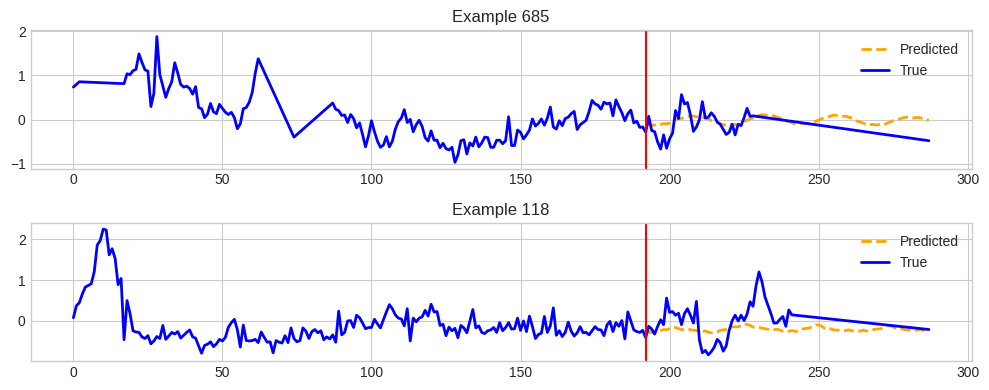

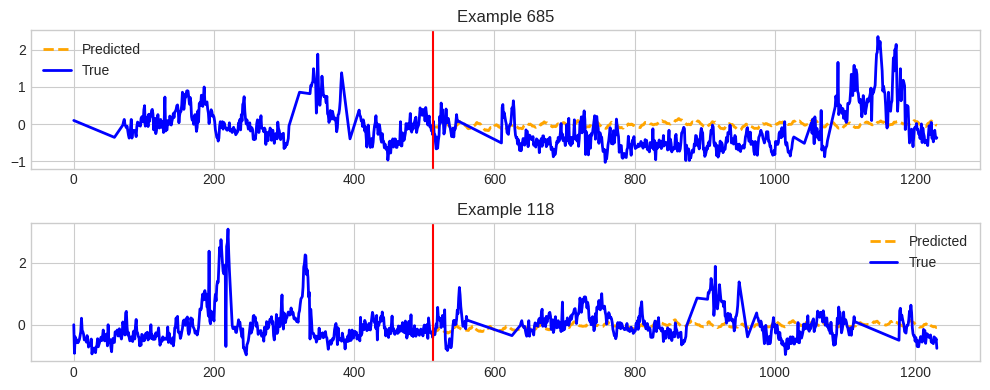

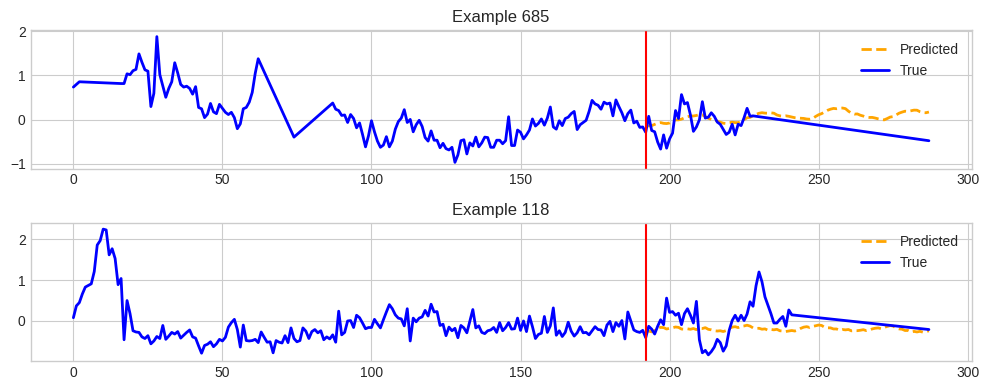

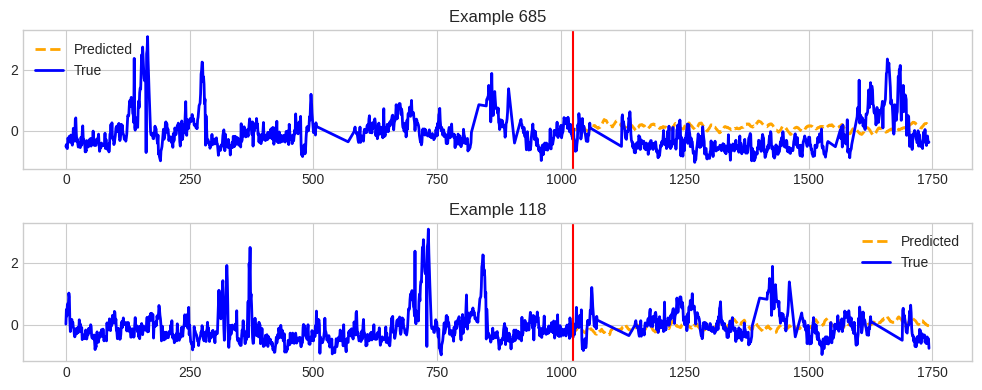

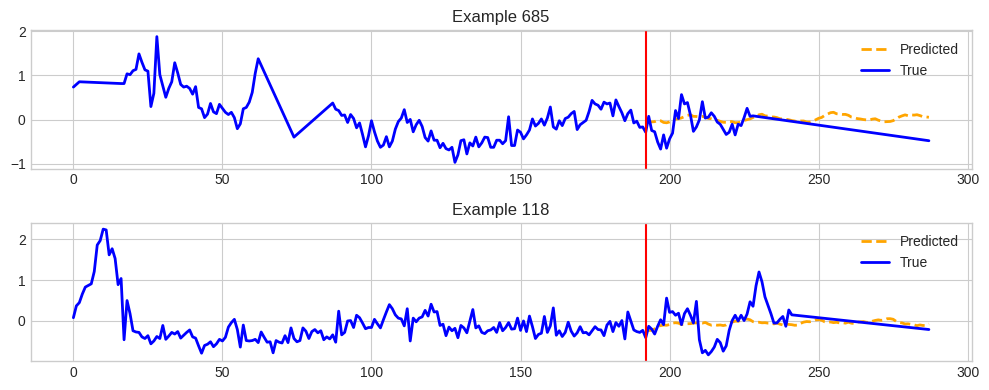

In [ ]:


d={}
c_l=[512,1024,1536]
f_l=[96,720]
for i in c_l:
  d[i]={}
  for j in f_l:

    a,b,c=fewshot_finetune_eval(
    dataset_name="PM25",
    context_length=i,
    forecast_length=j,
    batch_size=64,
    fewshot_percent=100,
    learning_rate=0.001)
    d[i][j]=[a,b,c]
print(json.dumps(d,indent=4))